In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download robinreni/signature-verification-dataset

 99% 594M/601M [00:04<00:00, 146MB/s]
100% 601M/601M [00:04<00:00, 137MB/s]


In [6]:
! unzip signature-verification-dataset.zip

Archive:  signature-verification-dataset.zip
  inflating: sign_data/sign_data/test/049/01_049.png  
  inflating: sign_data/sign_data/test/049/02_049.png  
  inflating: sign_data/sign_data/test/049/03_049.png  
  inflating: sign_data/sign_data/test/049/04_049.png  
  inflating: sign_data/sign_data/test/049/05_049.png  
  inflating: sign_data/sign_data/test/049/06_049.png  
  inflating: sign_data/sign_data/test/049/07_049.png  
  inflating: sign_data/sign_data/test/049/08_049.png  
  inflating: sign_data/sign_data/test/049/09_049.png  
  inflating: sign_data/sign_data/test/049/10_049.png  
  inflating: sign_data/sign_data/test/049/11_049.png  
  inflating: sign_data/sign_data/test/049/12_049.png  
  inflating: sign_data/sign_data/test/049_forg/01_0114049.PNG  
  inflating: sign_data/sign_data/test/049_forg/01_0206049.PNG  
  inflating: sign_data/sign_data/test/049_forg/01_0210049.PNG  
  inflating: sign_data/sign_data/test/049_forg/02_0114049.PNG  
  inflating: sign_data/sign_data/test/0

In [7]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [8]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
6.300947455999989
GPU (s):
0.06127502100000015
GPU speedup over CPU: 102x


## **Signature Verification using CNN Model**

In [23]:
from keras.preprocessing.image import ImageDataGenerator
import keras
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [24]:
!mkdir Train
!mkdir Test
!mkdir Train/Fake
!mkdir Train/Real

!mkdir Test/Fake
!mkdir Test/Real

mkdir: cannot create directory ‘Train’: File exists
mkdir: cannot create directory ‘Test’: File exists
mkdir: cannot create directory ‘Train/Fake’: File exists
mkdir: cannot create directory ‘Train/Real’: File exists
mkdir: cannot create directory ‘Test/Fake’: File exists
mkdir: cannot create directory ‘Test/Real’: File exists


In [25]:
# I'm re-positioning the train data so that keras can read it.
PATH = "sign_data/train/"

for i in os.listdir(PATH):
    
    contol = i.split("_")
    
    try:
    
        if contol[1]=="forg":
            
            os.system("cp -r {} Train/Fake".format(PATH+i))
            
    except:
        
        os.system("cp -r {} Train/Real".format(PATH+i))

In [26]:
# I'm re-positioning the test data so that keras can read it.
# I'm re-positioning the test data so that keras can read it.
PATH = "sign_data/test/"

for i in os.listdir(PATH):
    
    contol = i.split("_")
    
    try:
    
        if contol[1]=="forg":
            
            os.system("cp -r {} Test/Fake".format(PATH+i))
            
    except:
        
        os.system("cp -r {} Test/Real".format(PATH+i))

In [27]:
# Dataset locations
train_dir = os.path.join("Train") 
test_dir = os.path.join("Test") 

In [28]:
train_datagen = ImageDataGenerator(

      # Compressing picture pixels between 0,1
      rescale=1./255,

      # Angle of random rotation of images in degrees (0-180)
      rotation_range=40,

      # Horizontal and vertical scrolling rates of images
      width_shift_range=0.2,

      # Horizontal and vertical scrolling rates of images
      height_shift_range=0.2,

      # Buckling process
      shear_range=0.2,

      # Zoom operation
      zoom_range=0.2,

      # Rotate image vertically
      horizontal_flip=True,

      # Excess after processing
      # Determines how to fill image points
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [29]:
train_generator = train_datagen.flow_from_directory(

        # Target directory
        train_dir,

        # All images will be resized as (150x150)
        target_size=(200, 200),

        # Stack size
        batch_size=64,

        # Since we are using binary_crossentropy
        # Binary tags are required.
        class_mode='binary')

print(train_generator)

Found 1649 images belonging to 2 classes.


In [30]:
test_generator = test_datagen.flow_from_directory(

        test_dir,

        target_size=(200, 200),

        batch_size=64,

        class_mode='binary')

Found 500 images belonging to 2 classes.


Label :  0.0


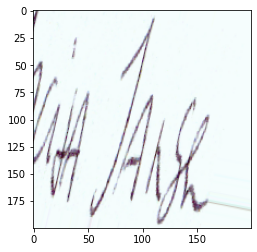

In [31]:
plt.imshow(train_generator[0][0][5])
print("Label : ",train_generator[0][1][5])

Label :  1.0


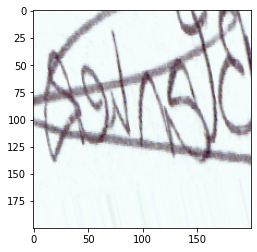

In [32]:
plt.imshow(train_generator[0][0][60])
print("Label : ",train_generator[0][1][60])

In [33]:
class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    
    self.cnn1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(3,200,200))
    self.cnn2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')
    self.cnn3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')
    self.cnn4 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')
    
    self.flatten = tf.keras.layers.Flatten()
    
    self.dense1 = tf.keras.layers.Dense(512, activation='relu')
    self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')

  def call(self, inputs):
    
    x = self.cnn1(inputs)
    x = self.cnn2(x)
    x = self.cnn3(x)
    x = self.cnn4(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    
    return x

model = MyModel()

In [34]:
input_shape = (None, 200, 200, 3)
model.build(input_shape)
model.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          multiple                  448       
                                                                 
 conv2d_28 (Conv2D)          multiple                  4640      
                                                                 
 conv2d_29 (Conv2D)          multiple                  9248      
                                                                 
 conv2d_30 (Conv2D)          multiple                  4624      
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  301990400 
                                                                 
 dense_3 (Dense)             multiple                  5

In [35]:
model.compile(
    # Loss function
    loss="binary_crossentropy",
    
    # Optimization:
    # Considering the loss created by the data, which is the input of our network.
    # Self-update mechanism
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),

    # Metrics to track during training and testing.
    metrics=["acc"])

In [36]:
## We will get the acc, loss, val_acc, val_loss values ​​from the variable named history.
history = model.fit(

    # Training data
    train_generator,

    # The number of samples it will run through until the loop finishes (stack to get)
    steps_per_epoch=train_generator.samples//train_generator.batch_size,

    # Number of cycles
    epochs=100,

    verbose=2)

Epoch 1/100
25/25 - 24s - loss: 1.1948 - acc: 0.4978 - 24s/epoch - 945ms/step
Epoch 2/100
25/25 - 20s - loss: 0.8095 - acc: 0.5274 - 20s/epoch - 797ms/step
Epoch 3/100
25/25 - 20s - loss: 0.7386 - acc: 0.5319 - 20s/epoch - 807ms/step
Epoch 4/100
25/25 - 21s - loss: 0.7278 - acc: 0.5609 - 21s/epoch - 845ms/step
Epoch 5/100
25/25 - 20s - loss: 0.6774 - acc: 0.5754 - 20s/epoch - 791ms/step
Epoch 6/100
25/25 - 20s - loss: 0.6555 - acc: 0.6082 - 20s/epoch - 783ms/step
Epoch 7/100
25/25 - 20s - loss: 0.6480 - acc: 0.6101 - 20s/epoch - 784ms/step
Epoch 8/100
25/25 - 21s - loss: 0.5902 - acc: 0.6858 - 21s/epoch - 821ms/step
Epoch 9/100
25/25 - 19s - loss: 0.5949 - acc: 0.6877 - 19s/epoch - 778ms/step
Epoch 10/100
25/25 - 20s - loss: 0.5901 - acc: 0.6669 - 20s/epoch - 780ms/step
Epoch 11/100
25/25 - 20s - loss: 0.5565 - acc: 0.7142 - 20s/epoch - 780ms/step
Epoch 12/100
25/25 - 20s - loss: 0.5523 - acc: 0.7268 - 20s/epoch - 785ms/step
Epoch 13/100
25/25 - 20s - loss: 0.5420 - acc: 0.7319 - 20s/e

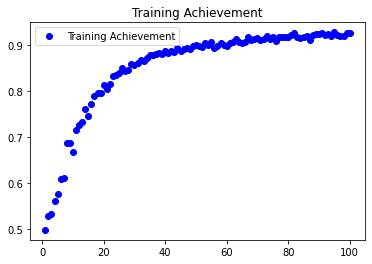

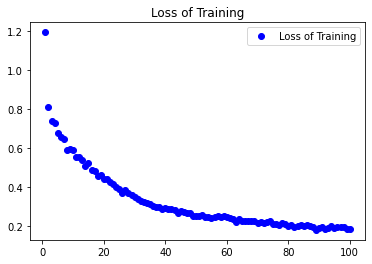

In [37]:
# Training achievement score
acc = history.history["acc"]

# Training loss score
loss = history.history["loss"]

# We will plot graphs according to the number of epochs.
epochs = range(1, len(acc) + 1)

# We had the training success drawn for it.
plt.plot(epochs, acc, "bo", label="Training Achievement")

# The title of our drawing
plt.title("Training Achievement")

plt.legend()

plt.figure()

# We have drawn the loss of training for it
plt.plot(epochs, loss, "bo", label="Loss of Training")


# The title of our drawing
plt.title("Loss of Training")

plt.legend()

# Display on screen
plt.show()

In [38]:
# Loss and verification with test data
model.evaluate(test_generator)

8/8 [==============================] - 3s 365ms/step - loss: 0.2881 - acc: 0.8640


[0.28809279203414917, 0.8640000224113464]

Label :  1.0
Predict :  0.0


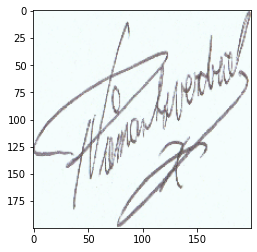

In [39]:
plt.imshow(test_generator[0][0][5])
print("Label : ",test_generator[0][1][5])

test_input = test_generator[0][0][5]
test_input = np.expand_dims(test_input,axis=0)
test_input = np.expand_dims(test_input,axis=0)
test_input = np.expand_dims(test_input,axis=0)

pred = model.predict(test_input)

if pred>=0.5:
    pred = 1
    
else:
    
    pred = 0
    
print("Predict : ",float(pred))

Label :  1.0
Predict :  1.0


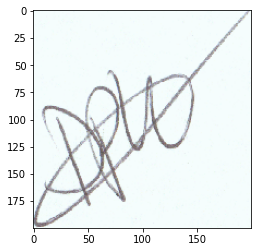

In [40]:
plt.imshow(test_generator[0][0][30])
print("Label : ",test_generator[0][1][30])

test_input = test_generator[0][0][30]
test_input = np.expand_dims(test_input,axis=0)
test_input = np.expand_dims(test_input,axis=0)
test_input = np.expand_dims(test_input,axis=0)

pred = model.predict(test_input)

if pred>=0.5:
    pred = 1
    
else:
    
    pred = 0
    
print("Predict : ",float(pred))